<a href="https://colab.research.google.com/github/DiaaEddinH/ML-python-project/blob/main/DrugRatingPredictionbyReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

The purpose of this project is to employ machine learning algorithms on the UCI drug review dataset.
The UCI ML Drug Review dataset provides patient reviews on specific drugs along with related conditions and a 10-star patient rating system reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. This data was published in a study on sentiment analysis of drug experience over multiple facets, ex. sentiments learned on specific aspects such as effectiveness and side effects (see the acknowledgments section to learn more).

#Regression
A first approach for working with this dataset would be as a regression problem i.e. "Can we predict the ratings of a drug based on the review ?" 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from keras.preprocessing import text, sequence

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
!unzip drugsCom_raw.zip

train_file = "drugsComTrain_raw.tsv"
test_file = "drugsComTest_raw.tsv"

--2021-03-25 16:07:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  14.4MB/s    in 2.9s    

2021-03-25 16:07:04 (14.4 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


We load the data we are going to use for the training of our model. Initially, we sampled a smaller dataset to facilitate trial and error in creating the model.

In [ ]:
#Set parameters for the text-processing
VOCAB_SIZE = 12000
MAX_LEN = 300

def process_reviews(reviews, token):
  wide = token.texts_to_matrix(reviews)
  deep = token.texts_to_sequences(reviews)
  deep = sequence.pad_sequences(deep, maxlen=MAX_LEN)

  return [wide, deep]

def norm_data(df_data):
  return (df_data - df_data.mean())/df_data.std()

In [ ]:
#Load data
df_train = pd.read_csv(train_file, sep="\t")
df_test = pd.read_csv(test_file, sep="\t")

# #Normalize data
# df_train['rating'] = norm_data(df_train.rating)
# df_test['rating'] = norm_data(df_test.rating)

#Use only reviews that have been rated useful by, at least 100, users
df_train = df_train[~df_train['usefulCount'].map(df_train.usefulCount.value_counts()).lt(100)]
df_test = df_test[~df_test['usefulCount'].map(df_test.usefulCount.value_counts()).lt(100)]

df_train['review'] = df_train['review'].replace({"&#039;":"'"}, regex=True)
df_test['review'] = df_test['review'].replace({"&#039;":"'"}, regex=True)

#Normalize the data
# df_train['rating'] = df_train['rating']/10.
# df_test['rating'] = df_test['rating']/10.

#Sample 10k from train data and 2k from test data for initial testing.
#Create dataset with rating and review for training
train_data = df_train[['review','rating']].sample(frac=0.8, random_state=0)
val_data = df_train[['review','rating']].drop(train_data.index)
test_data = df_test[['review','rating']]

#Create labels
train_labels = train_data.pop('rating')
val_labels = val_data.pop('rating')
test_labels = test_data.pop('rating')

#Processing training data
token = text.Tokenizer(num_words=VOCAB_SIZE, char_level=False)
token.fit_on_texts(train_data.review)

We are going to employ a "wide & deep learning" model.

In [ ]:
#lr_sched = keras.optimizers.schedules.ExponentialDecay(0.001, 1000, 0.96)
opt = keras.optimizers.SGD(learning_rate=0.01)

#Wide model network
wide_input = layers.Input(shape=(VOCAB_SIZE,))
inter = layers.Dense(64, activation='relu')(wide_input)
#inter = layers.Dropout(0.3)(inter)
predictions = layers.Dense(1)(inter)
wide_model = keras.Model(inputs=wide_input, outputs=predictions)
wide_model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

#Deep model network
deep_input = layers.Input(shape=(MAX_LEN,))
embed = layers.Embedding(VOCAB_SIZE, 16, input_length=MAX_LEN)(deep_input)
#embed = layers.LSTM(32)(embed)
embed = layers.Flatten()(embed)
embed = layers.Dense(10, activation='relu')(embed)
#embed = layers.Dropout(0.3)(embed)
embed_out = layers.Dense(1)(embed)
deep_model = keras.Model(inputs=deep_input, outputs=embed_out)
deep_model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

#Combine wide and deep models into one model
merge_out = layers.concatenate([wide_model.output, deep_model.output])
merge_out = layers.Dense(10, activation='relu')(merge_out)
#merge_out = layers.Dropout(0.3)(merge_out)
merge_out = layers.Dense(1)(merge_out)
model = keras.Model([wide_model.input, deep_model.input], merge_out)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

Using a sample of 10k seems to give quite a low accuracy, resulting in a significant deviation. My goal is to reduce this deviation within the range of a unit. So, I will introduce the whole dataset, but this time will train the model using a generator due to its volume and our available memory.

In [ ]:
def dataGen(data_reviews, data_labels, token, batch_size=32, seq_len=MAX_LEN):
  #'Generates data containing batch_size samples'
  batch_num = 0
  dataset_len = len(data_reviews)
  batches_per_epoch = int(dataset_len/batch_size)

  while True:
    initial = (batch_num*batch_size) % dataset_len
    final = initial + batch_size
    temp_reviews = data_reviews[initial:final]
    temp_labels = data_labels[initial:final]

    x = process_reviews(temp_reviews, token)
    y = np.asarray(temp_labels)

    batch_num = (batch_num + 1) % batches_per_epoch
    yield x,y

def test_dataGen(data_reviews, token, batch_size=32, seq_len=MAX_LEN):
  #'Generates data containing batch_size samples'
  batch_num = 0
  dataset_len = len(data_reviews)
  batches_per_epoch = int(dataset_len/batch_size)

  while True:
    initial = (batch_num*batch_size) % dataset_len
    final = initial + batch_size
    temp_reviews = data_reviews[initial:final]

    x = process_reviews(temp_reviews, token)

    batch_num = (batch_num + 1) % batches_per_epoch
    yield x

In [ ]:
def on_epoch_end(epoch, logs, print_predictions=0):
    # Generate predictions
    predictions = model.predict(
        test_dataGen(test_data.review, token, 128),
        steps=int(len(test_data)/128)
    )

    # Compare predictions with actual values for the first few items in our test dataset
    diff = 0
    printed = 0
    for i in range(len(predictions)):
        val = predictions[i]
        if print_predictions and printed < print_predictions:
            print(test_data.review.iloc[i])
            print(f'Predicted: {val[0]:.2f} \t Actual: {test_labels.iloc[i]} \n')
            printed += 1
        diff += abs(val[0] - test_labels.iloc[i])

    # Compare the average difference between actual price and the model's predicted price
    print(f'\nEpoch: {epoch+1}. Average prediction difference: {diff/len(predictions):0.4f}\n')
    #print(f'Mean absolute error: {logs["mean_absolute_error"]:.3f}\n')
    
    
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience = 3)
print_callback = keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
batch_size = 128

In [ ]:
history = model.fit(
    dataGen(train_data.review,train_labels, token, batch_size = batch_size),
    steps_per_epoch = int(len(train_data)/batch_size),
    validation_data = dataGen(val_data.review, val_labels, token, batch_size = batch_size),
    validation_steps = int(len(val_data)/batch_size),
    epochs = 10#,
    #callbacks = [print_callback]
    )

Epoch 1/10
981/981 [==============================] - 42s 43ms/step - loss: 0.2147 - accuracy: 0.1365 - val_loss: 3.7148 - val_accuracy: 0.1361
Epoch 2/10
981/981 [==============================] - 41s 42ms/step - loss: 0.2000 - accuracy: 0.1365 - val_loss: 3.6530 - val_accuracy: 0.1367
Epoch 3/10
981/981 [==============================] - 42s 43ms/step - loss: 0.1935 - accuracy: 0.1365 - val_loss: 3.6693 - val_accuracy: 0.1367
Epoch 4/10
981/981 [==============================] - 42s 42ms/step - loss: 0.1900 - accuracy: 0.1366 - val_loss: 3.6286 - val_accuracy: 0.1370
Epoch 5/10
981/981 [==============================] - 41s 42ms/step - loss: 0.1867 - accuracy: 0.1365 - val_loss: 3.6505 - val_accuracy: 0.1368
Epoch 6/10
981/981 [==============================] - 41s 42ms/step - loss: 0.1851 - accuracy: 0.1366 - val_loss: 3.6563 - val_accuracy: 0.1369
Epoch 7/10
981/981 [==============================] - 41s 42ms/step - loss: 0.1775 - accuracy: 0.1366 - val_loss: 3.6288 - val_accuracy:

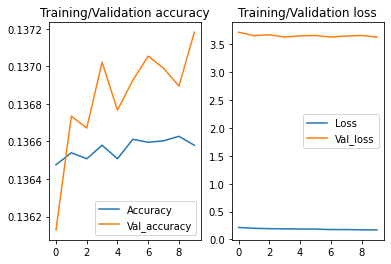

In [ ]:
#Prepare plotting
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.subplot(1,2,1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Val_accuracy')
plt.title('Training/Validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val_loss')
plt.title('Training/Validation loss')
plt.legend()

We take a look at a sample of reviews, as well as, the rating the model predicts versus the actual one.
The model performs quite well and within my expectations. There is little deviation with the majority of reviews, but performs poorly when the review has sentiment that the model hasn't been trained to pick up on e.g. sarcasm, passive-aggression, etc. or when the review is too short of words.

In [ ]:
on_epoch_end(10, {}, print_predictions=10)

"I've tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I've actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me."
Predicted: 9.50 	 Actual: 10.0 

"My son has Crohn's disease and has done very well on the Asacol.  He has no complaints and shows no side effects.  He has taken as many as nine tablets per day at one time.  I've been very happy with the results, reducing his bouts of diarrhea drastically."
Predicted: 9.28 	 Actual: 8.0 

"Quick reduction of symptoms"
Predicted: 9.09 	 Actual: 9.0 

"Contrave combines drugs that were used for alcohol, smoking, and opioid cessation. People lose weight on it because it also helps control over-eating. I have no doubt that most obesit

#Future considerations


*   Optimize training data by removing capitalisations, stop words, words that occur frequently, but offer no use, e.g. that, the, is, are, etc.

* Use pre-trained word vectors such as [GLoVe](https://nlp.stanford.edu/projects/glove/) for our embeddings.

* Build more complex networks using a simple RNN or an LSTM network.



# Acknowledgments

The dataset was originally published on the UCI Machine Learning repository. 

Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125.